# Imoports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import time
from IPython.display import clear_output as c

from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
)

import catboost
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

# Get data

In [38]:
df = pd.read_csv('C://Users/nuats/datasets/Keystrokes/files/135510_keystrokes.txt', sep='\t')

for i in range(5, 50):
    
    for j in range(93012+8500*i, 93012+8500*(i+1)):
        print(j)
        try:
            tmp = pd.read_csv(f'C://Users/nuats/datasets/Keystrokes/files/{j}_keystrokes.txt', sep='\t')
            df = pd.concat([df, tmp], axis=0)
            c()
        except:
            c()
            pass
    
    df.reset_index(drop=True, inplace=True)
    df.columns = df.columns.str.lower()
    
    df['test_section_id'] = pd.to_numeric(df['test_section_id'], errors='coerce')
    df = df.dropna(subset=['test_section_id'])
    df.to_parquet(f'136m_dataset_part{i+3}.parquet')
    
    df = tmp.copy()

In [3]:
df = pd.read_parquet('136m_dataset_part1.parquet')
df.columns = df.columns.str.lower()
for i in range(2, 5):
    tmp = pd.read_parquet(f'136m_dataset_part{i}.parquet')
    tmp.columns = tmp.columns.str.lower()
    df = pd.concat([df, tmp], axis=0)
print(df.shape)
df.head(2)

(25885872, 9)


,participant_id,test_section_id,sentence,user_input,keystroke_id,press_time,release_time,letter,keycode
0,5.0,7,The others raise their eyebrows.,The others raise their eyebrows,204.0,1.471934e+12,1.471934e+12,SHIFT,16.0
1,5.0,7,The others raise their eyebrows.,The others raise their eyebrows,203.0,1.471934e+12,1.471934e+12,T,84.0


In [3]:
df = pd.read_parquet('136m_dataset_part1.parquet')
df.columns = df.columns.str.lower()

# EDA

In [3]:
n_participants = df['participant_id'].nunique()
avg_length_sent = df.shape[0] / df['test_section_id'].nunique()
avg_unique_sent = df['test_section_id'].nunique() / n_participants
print(f'''
Number of unique participants: {n_participants}
Average length of sentences: {round(avg_length_sent, 2)}
Average unique senteces: {round(avg_unique_sent, 2)}
''')


Number of unique participants: 10008
Average length of sentences: 48.46
Average unique senteces: 14.99



In [4]:
df['letter'] = df['letter'].str.replace(' ', 'space').str.lower()
df['sentence_length'] = df['user_input'].str.len()

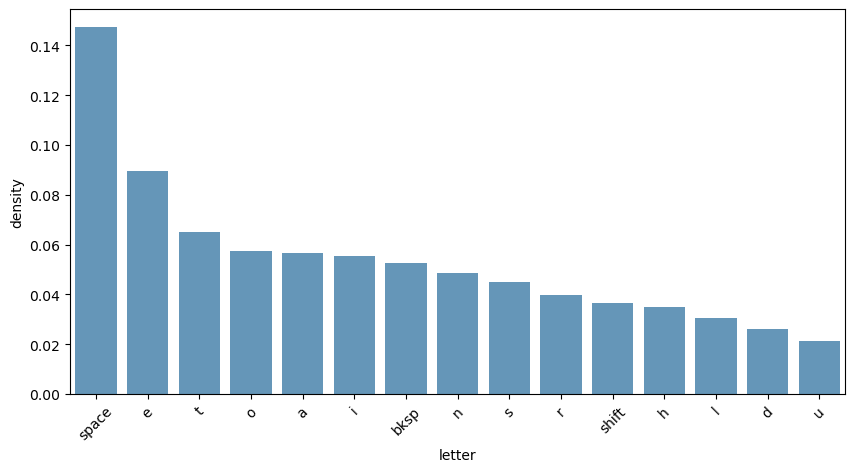

In [10]:
tmp = df['letter'].value_counts(-1).round(4).iloc[:15].reset_index().rename(columns={'index': 'letter', 'letter': 'density'})

plt.figure(figsize=(10, 5))
sns.barplot(x=tmp['letter'], y=tmp['density'], color='#5799C6')#palette='ch:start=-.85,rot=.1,dark=.8,light=.6')
plt.xticks(rotation=45)
# plt.savefig('top_letters.png')
plt.show()

ValueError: cannot reindex on an axis with duplicate labels

<Figure size 1000x500 with 0 Axes>

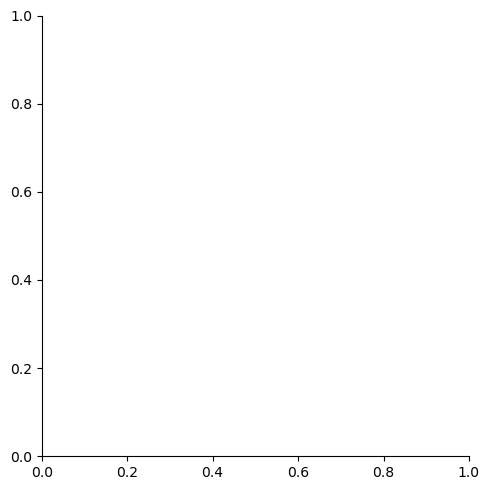

In [12]:
tmp = df.drop_duplicates(subset='test_section_id').sample(50_000)

plt.figure(figsize=(10, 5))
sns.displot(data=tmp, x='sentence_length', kind='hist', bins=15, stat='density', palette='ch:start=-.85,rot=.1,dark=.8,light=.6')
# plt.savefig('sentence_length.png')

In [ ]:
minutes = (df.groupby(['participant_id']).release_time.last() - df.groupby(['participant_id']).press_time.first()) / 1000 / 60
words = (df[df.letter == 'space'].groupby(['participant_id']).letter.count() + 1)
wpm = words / minutes
wpm = wpm.to_frame().rename(columns={0: 'Words per minute'})

plt.figure(figsize=(10, 5))
sns.displot(data=wpm, x='Words per minute', kind='hist', bins=22, stat='density', palette='ch:start=-.85,rot=.1,dark=.8,light=.6')
# plt.savefig('words_per_minute.png')

In [ ]:
tmp = (df[df.letter == 'bksp'].groupby(['participant_id']).letter.count() / 
       df.groupby(['participant_id']).letter.count()).to_frame().rename(columns={'letter': 'Corrected error rate %'}) * 100

plt.figure(figsize=(10, 5))
sns.displot(data=tmp, x='Corrected error rate %', kind='hist', bins=22, stat='density', palette='ch:start=-.85,rot=.1,dark=.8,light=.6')
# plt.savefig('error_rate.png')

# Feature engineering

In [5]:
df['pre_press_time'] = df.groupby(['participant_id', 'test_section_id'])['press_time'].shift(1)
df['pre_release_time'] = df.groupby(['participant_id', 'test_section_id'])['release_time'].shift(1)
df['delta'] = df['release_time'] - df['press_time']
df['flight_1'] = df['release_time'] - df['pre_press_time']
df['flight_2'] = df['release_time'] - df['pre_release_time']
df['flight_3'] = df['press_time'] - df['pre_press_time']
df['flight_4'] = df['press_time'] - df['pre_release_time']
df['sentence_length'] = df['user_input'].str.len()
df['id'] = df.set_index(['participant_id','test_section_id']).index.factorize()[0]+1
df.drop(columns=['test_section_id', 'keystroke_id'], inplace=True)
c()
df.head(2)

,participant_id,sentence,user_input,press_time,release_time,letter,keycode,sentence_length,pre_press_time,pre_release_time,delta,flight_1,flight_2,flight_3,flight_4,id
0,5.0,The others raise their eyebrows.,The others raise their eyebrows,1.471934e+12,1.471934e+12,shift,16.0,31.0,NaN,NaN,168.0,NaN,NaN,NaN,NaN,1
1,5.0,The others raise their eyebrows.,The others raise their eyebrows,1.471934e+12,1.471934e+12,t,84.0,31.0,1.471934e+12,1.471934e+12,59.0,168.0,0.0,109.0,-59.0,1


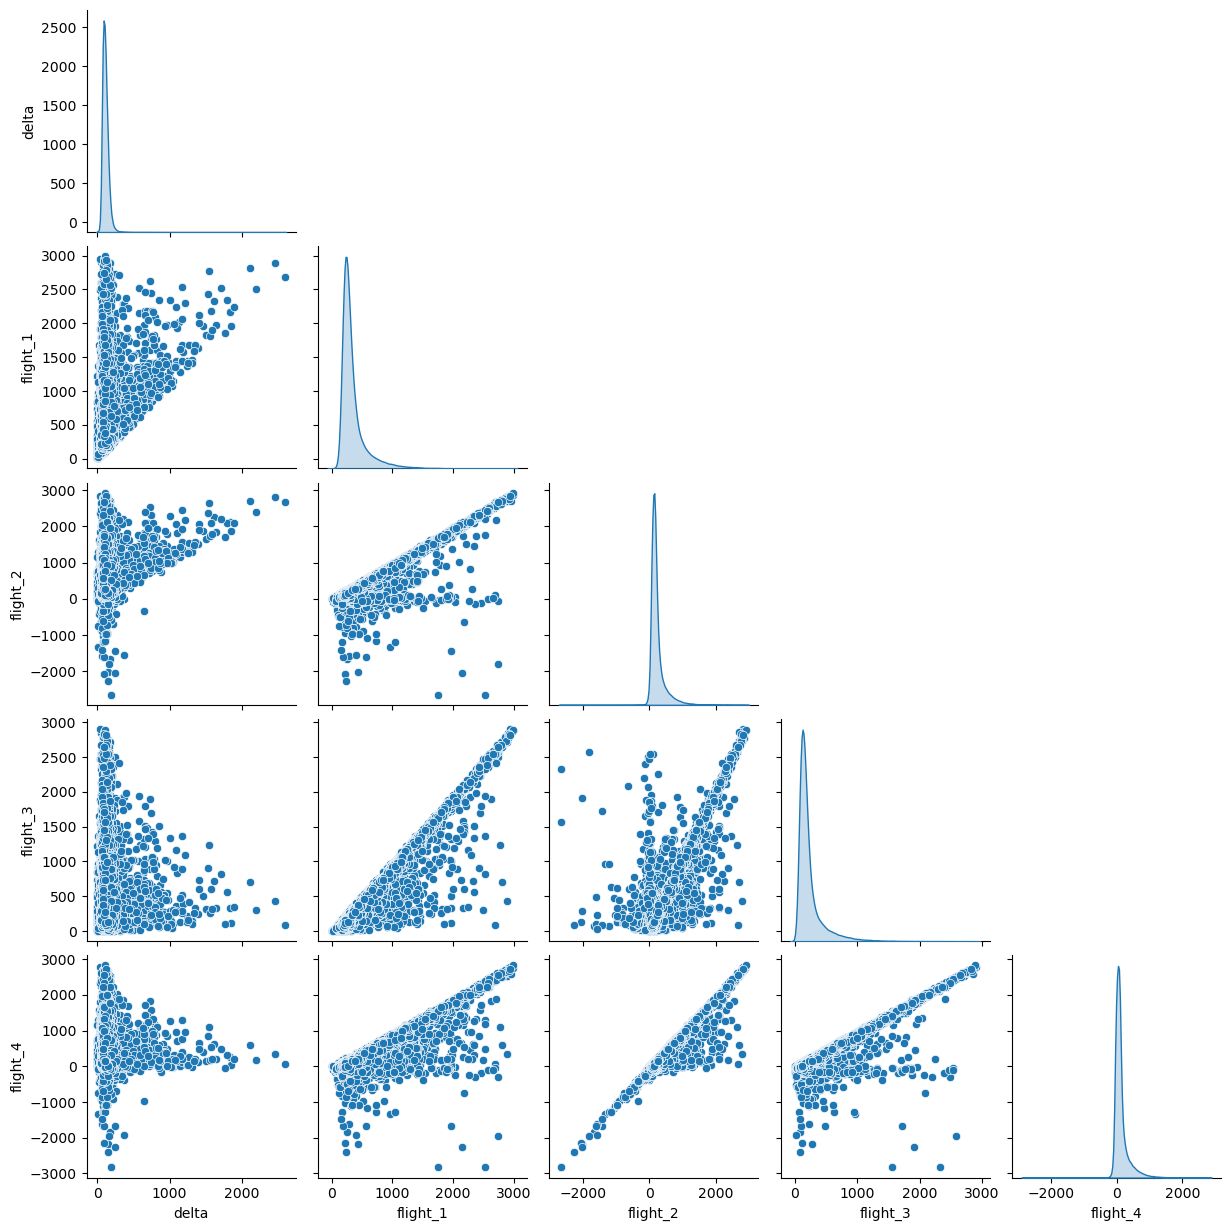

In [388]:
tmp = df.sample(10**5).iloc[:,-7:-2]
pairplot = sns.pairplot(tmp, diag_kind="kde")
for i in range(tmp.shape[1]):
    for j in range(i + 1, tmp.shape[1]):
        pairplot.axes[i, j].set_visible(False)
# pairplot.map_lower(sns.kdeplot, levels=4, color=".2")
# plt.savefig('pairplot.png')
plt.show()

In [6]:
feats = ['delta']#, 'flight_1', 'flight_2', 'flight_3', 'flight_4']
for feat in feats:
    tmp1 = df[feat].mean() + 3*df[feat].std()
    tmp2 = df[feat].mean() - 3*df[feat].std()
    df = df[(df[feat] <= tmp1) & (df[feat] >= tmp2)]

In [7]:
print(df.shape[0])
df = df[(df['delta'] > -3000) & (df['delta'] < 3000)]
df = df[(df['flight_1'] > -3000) & (df['flight_1'] < 3000)]
df = df[(df['flight_2'] > -3000) & (df['flight_2'] < 3000)]
df = df[(df['flight_3'] > -3000) & (df['flight_3'] < 3000)]
df = df[(df['flight_4'] > -3000) & (df['flight_4'] < 3000)]
print(df.shape[0])

7259637
7107124


In [ ]:
по каждой фиче (х5)
среднее
стандартное отклонение
по топ 5 клавиш среднее + стд
итого 35 фичей
+ длина предложения

**фичи**

In [8]:
features = pd.DataFrame(df['id'].unique(), columns=['id'])

features['sentence_length'] = features['id'].map(df.groupby(['participant_id', 'id'])['sentence_length'].max().droplevel(0))

mapping = df.groupby(['participant_id', 'id'])['delta'].agg(['mean', 'std']).droplevel(0)
features['delta_avg'] = features['id'].map(mapping['mean'])
features['delta_std'] = features['id'].map(mapping['std'])

for i in range(1, 5):
    mapping = df.groupby(['participant_id', 'id'])[f'flight_{i}'].agg(['mean', 'std']).droplevel(0)
    features[f'flight_type{i}_avg'] = features['id'].map(mapping['mean'])
    features[f'flight_type{i}_std'] = features['id'].map(mapping['std'])

most_common_keys = df['letter'].str.lower().value_counts(-1).iloc[:7].index.to_list()
for key in most_common_keys:
    group_key = df[df['letter'] == key]
    
    mapping = group_key.groupby(['participant_id', 'id'])['delta'].agg(['mean', 'std']).droplevel(0)
    features[f'delta_avg_key_{key}'] = features['id'].map(mapping['mean'])
    features[f'delta_std_key_{key}'] = features['id'].map(mapping['std'])
    
    for i in range(1, 5):
        mapping = group_key.groupby(['participant_id', 'id'])[f'flight_{i}'].agg(['mean', 'std']).droplevel(0)
        features[f'flight_type{i}_avg_key_{key}'] = features['id'].map(mapping['mean'])
        features[f'flight_type{i}_std_key_{key}'] = features['id'].map(mapping['std'])

print(features.shape)
features.head(2)

(150058, 82)


,id,sentence_length,delta_avg,delta_std,flight_type1_avg,flight_type1_std,flight_type2_avg,flight_type2_std,flight_type3_avg,flight_type3_std,flight_type4_avg,flight_type4_std,delta_avg_key_space,delta_std_key_space,flight_type1_avg_key_space,flight_type1_std_key_space,flight_type2_avg_key_space,flight_type2_std_key_space,flight_type3_avg_key_space,flight_type3_std_key_space,flight_type4_avg_key_space,flight_type4_std_key_space,delta_avg_key_e,delta_std_key_e,flight_type1_avg_key_e,flight_type1_std_key_e,flight_type2_avg_key_e,flight_type2_std_key_e,flight_type3_avg_key_e,flight_type3_std_key_e,flight_type4_avg_key_e,flight_type4_std_key_e,delta_avg_key_t,delta_std_key_t,flight_type1_avg_key_t,flight_type1_std_key_t,flight_type2_avg_key_t,flight_type2_std_key_t,flight_type3_avg_key_t,flight_type3_std_key_t,flight_type4_avg_key_t,flight_type4_std_key_t,delta_avg_key_o,delta_std_key_o,flight_type1_avg_key_o,flight_type1_std_key_o,flight_type2_avg_key_o,flight_type2_std_key_o,flight_type3_avg_key_o,flight_type3_std_key_o,flight_type4_avg_key_o,flight_type4_std_key_o,delta_avg_key_a,delta_std_key_a,flight_type1_avg_key_a,flight_type1_std_key_a,flight_type2_avg_key_a,flight_type2_std_key_a,flight_type3_avg_key_a,flight_type3_std_key_a,flight_type4_avg_key_a,flight_type4_std_key_a,delta_avg_key_i,delta_std_key_i,flight_type1_avg_key_i,flight_type1_std_key_i,flight_type2_avg_key_i,flight_type2_std_key_i,flight_type3_avg_key_i,flight_type3_std_key_i,flight_type4_avg_key_i,flight_type4_std_key_i,delta_avg_key_bksp,delta_std_key_bksp,flight_type1_avg_key_bksp,flight_type1_std_key_bksp,flight_type2_avg_key_bksp,flight_type2_std_key_bksp,flight_type3_avg_key_bksp,flight_type3_std_key_bksp,flight_type4_avg_key_bksp,flight_type4_std_key_bksp
0,1,31.0,97.709677,19.938562,256.967742,127.453386,156.935484,131.632300,159.258065,129.372323,59.225806,133.080605,97.750000,14.03270,244.500000,26.551836,144.500000,34.219877,146.750000,34.042865,46.750000,45.973724,97.5,13.663821,196.5,38.166739,104.5,35.195170,99.0,41.923740,7.0,44.000000,93.0,31.096624,235.0,87.504286,105.333333,108.098720,142.0,62.425956,12.333333,78.232559,103.50,20.506097,270.5,44.547727,153.5,91.216775,167.00,24.041631,50.00,70.710678,90.000000,NaN,254.000000,NaN,137.000000,NaN,164.0,NaN,47.0,NaN,96.0,25.455844,544.5,481.539718,456.0,483.661038,448.5,506.995562,360.0,509.116882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,41.0,104.711111,57.469210,258.644444,112.999830,124.955556,233.714954,153.933333,103.025240,20.244444,226.061451,99.714286,22.31378,242.142857,21.644311,146.857143,40.486329,142.428571,34.131399,47.142857,57.935103,122.0,9.899495,207.5,9.192388,137.5,34.648232,85.5,19.091883,15.5,44.547727,101.5,19.091883,235.0,4.242641,148.500000,24.748737,133.5,23.334524,47.000000,43.840620,86.25,25.329495,226.5,17.710637,142.5,45.858478,140.25,15.261608,56.25,37.924267,109.666667,7.094599,285.666667,115.487373,172.666667,113.394591,176.0,114.424648,63.0,111.072049,53.0,NaN,190.0,NaN,53.0,NaN,137.0,NaN,0.0,NaN,72.0,NaN,231.0,NaN,-1158.0,NaN,159.0,NaN,-1230.0,NaN


In [9]:
def create_features(data, feats, n, local_name, flag_lengh=False):
    
    mapping = data.groupby(['participant_id', 'id'])['delta'].agg(['mean', 'std']).droplevel(0)
    feats[f'{local_name}_delta_avg'] = feats['id'].map(mapping['mean'])
    feats[f'{local_name}_delta_std'] = feats['id'].map(mapping['std'])
    
    if flag_lengh:
        feats[f'{local_name}_sentence_length'] = feats['id'].map(
            data.groupby(['participant_id', 'id'])['sentence_length'].max().droplevel(0)
        )
    
    for i in range(1, 5):
        mapping = data.groupby(['participant_id', 'id'])[f'flight_{i}'].agg(['mean', 'std']).droplevel(0)
        feats[f'{local_name}_flight_type{i}_avg'] = feats['id'].map(mapping['mean'])
        feats[f'{local_name}_flight_type{i}_std'] = feats['id'].map(mapping['std'])

    most_common_keys = df['letter'].str.lower().value_counts(-1).iloc[:n].index.to_list()
    for key in most_common_keys:
        group_key = df[df['letter'] == key]

        mapping = group_key.groupby(['participant_id', 'id'])['delta'].agg(['mean', 'std']).droplevel(0)
        feats[f'{local_name}_delta_avg_key_{key}'] = feats['id'].map(mapping['mean'])
        feats[f'{local_name}_delta_std_key_{key}'] = feats['id'].map(mapping['std'])

        for i in range(1, 5):
            mapping = group_key.groupby(['participant_id', 'id'])[f'flight_{i}'].agg(['mean', 'std']).droplevel(0)
            feats[f'{local_name}_flight_type{i}_avg_key_{key}'] = feats['id'].map(mapping['mean'])
            feats[f'{local_name}_flight_type{i}_std_key_{key}'] = feats['id'].map(mapping['std'])
            
    return feats

In [34]:
tmp = df.groupby('id').head(5)
feats_start = pd.DataFrame(tmp['id'].unique(), columns=['id'])
feats_start = create_features(tmp, feats_start, 1, 'start')

tmp = df.groupby('id').tail(5)
feats_end = pd.DataFrame(tmp['id'].unique(), columns=['id'])
feats_end = create_features(tmp, feats_end, 1, 'end')

tmp = df.groupby('id').apply(lambda x: x.iloc[5:-5]).reset_index(drop=True)
feats_mid = pd.DataFrame(tmp['id'].unique(), columns=['id'])
feats_mid = create_features(tmp, feats_mid, 1, 'mid', True)

In [57]:
feats = pd.merge(feats_start.iloc[:, :11], feats_end.iloc[:, :11], on='id', how='inner')
feats = feats.merge(feats_mid.iloc[:, :12], on='id', how='inner')
feats = feats.merge(features.iloc[:, :22].drop(columns='sentence_length'), on='id', how='inner')
feats.drop_duplicates(subset='id', inplace=True)

mapping = df[['id', 'participant_id']].drop_duplicates().set_index('id')
feats['participant_id'] = feats['id'].map(mapping['participant_id'])
feats['participant_id'] = feats['participant_id'].astype(int)

train = feats.groupby('participant_id').head(8)
test = feats[~feats['id'].isin(train['id'])]
test = test[test['participant_id'].isin(train['participant_id'])]
train = train[train['participant_id'].isin(test['participant_id'])]

train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)
c()

print(train.shape[0], test.shape[0], train.shape[0] + test.shape[0], features.shape[0])

x_train, y_train = train.iloc[:3000, :-1], train.iloc[:3000, -1]
x_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

80024 69997 150021 150058


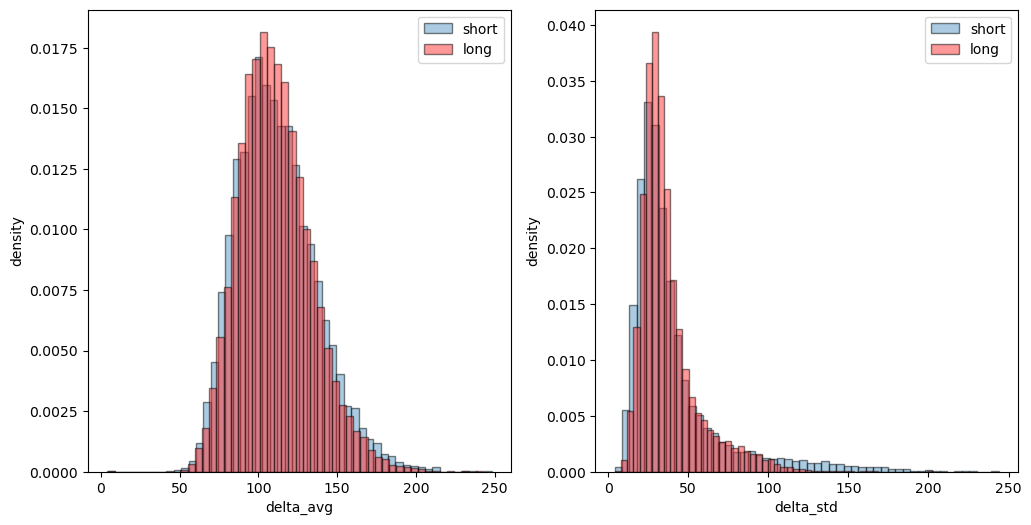

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(features[features.sentence_length <= 20].delta_avg, density=True, bins=52, color='#5799C6', alpha=0.5, edgecolor='black', label='short')
ax[0].hist(features[features.sentence_length > 60].delta_avg, density=True, bins=52, color='#ff3333', alpha=0.5, edgecolor='black', label='long')
ax[0].set_xlabel('delta_avg')
ax[0].set_ylabel('density')
ax[0].legend()

ax[1].hist(features[features.sentence_length <= 20].delta_std, density=True, bins=52, color='#5799C6', alpha=0.5, edgecolor='black', label='short')
ax[1].hist(features[features.sentence_length > 60].delta_std, density=True, bins=52, color='#ff3333', alpha=0.5, edgecolor='black', label='long')
ax[1].set_xlabel('delta_std')
ax[1].set_ylabel('density')
ax[1].legend()

plt.savefig('distribution_short_long_sent.png')
fig.show()

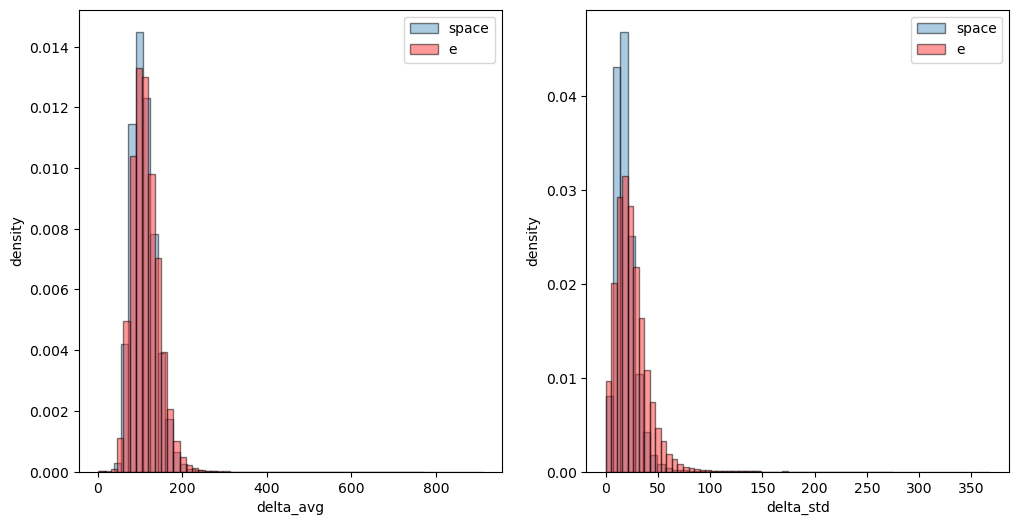

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(features.delta_avg_key_space, density=True, bins=52, color='#5799C6', alpha=0.5, edgecolor='black', label='space')
ax[0].hist(features.delta_avg_key_e, density=True, bins=52, color='#ff3333', alpha=0.5, edgecolor='black', label='e')
ax[0].set_xlabel('delta_avg')
ax[0].set_ylabel('density')
ax[0].legend()

ax[1].hist(features.delta_std_key_space, density=True, bins=52, color='#5799C6', alpha=0.5, edgecolor='black', label='space')
ax[1].hist(features.delta_std_key_e, density=True, bins=52, color='#ff3333', alpha=0.5, edgecolor='black', label='e')
ax[1].set_xlabel('delta_std')
ax[1].set_ylabel('density')
ax[1].legend()

plt.savefig('distribution_space_e.png')
fig.show()

In [65]:
tmp = df.groupby('id').apply(lambda x: x.iloc[5:-5]).reset_index(drop=True)
feats_mid = pd.DataFrame(tmp['id'].unique(), columns=['id'])

mapping = tmp.groupby(['participant_id', 'id'])['delta'].agg(['mean', 'std']).droplevel(0)
feats_mid['delta_avg'] = feats_mid['id'].map(mapping['mean'])
feats_mid['delta_std'] = feats_mid['id'].map(mapping['std'])
feats_mid['sentence_length'] = feats_mid['id'].map(tmp.groupby(['participant_id', 'id'])['sentence_length'].max().droplevel(0))


tmp = df.groupby('id').head(5)
feats_start = pd.DataFrame(tmp['id'].unique(), columns=['id'])

mapping = tmp.groupby(['participant_id', 'id'])['delta'].agg(['mean', 'std']).droplevel(0)
feats_start['delta_avg'] = feats_start['id'].map(mapping['mean'])
feats_start['delta_std'] = feats_start['id'].map(mapping['std'])


tmp = df.groupby('id').tail(5)
feats_end = pd.DataFrame(tmp['id'].unique(), columns=['id'])

mapping = tmp.groupby(['participant_id', 'id'])['delta'].agg(['mean', 'std']).droplevel(0)
feats_end['delta_avg'] = feats_end['id'].map(mapping['mean'])
feats_end['delta_std'] = feats_end['id'].map(mapping['std'])

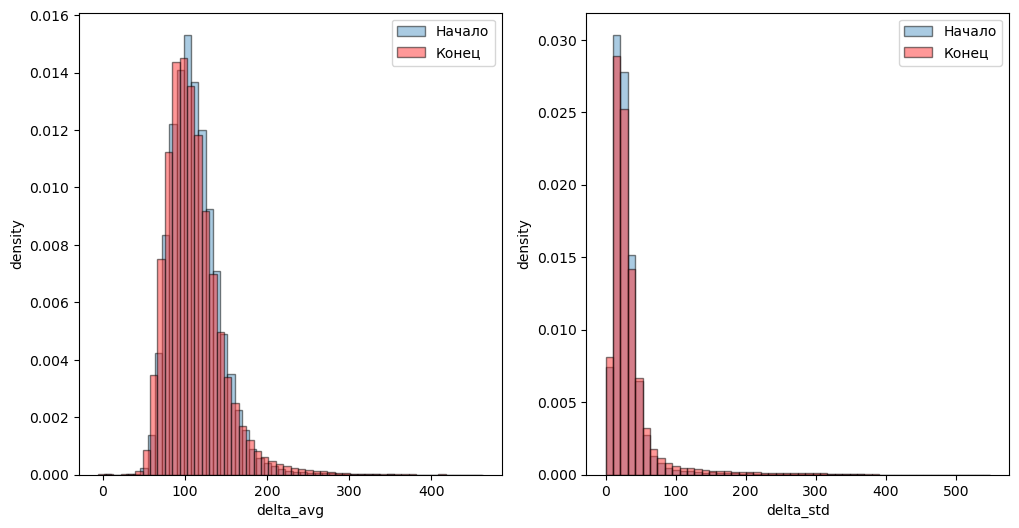

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(feats_start.delta_avg, density=True, bins=52, color='#5799C6', alpha=0.5, edgecolor='black', label='Начало')
ax[0].hist(feats_end.delta_avg, density=True, bins=52, color='#ff3333', alpha=0.5, edgecolor='black', label='Конец')
ax[0].set_xlabel('delta_avg')
ax[0].set_ylabel('density')
ax[0].legend()

ax[1].hist(feats_start.delta_std, density=True, bins=52, color='#5799C6', alpha=0.5, edgecolor='black', label='Начало')
ax[1].hist(feats_end.delta_std, density=True, bins=52, color='#ff3333', alpha=0.5, edgecolor='black', label='Конец')
ax[1].set_xlabel('delta_std')
ax[1].set_ylabel('density')
ax[1].legend()

plt.savefig('distribution_first_last_5.png')
fig.show()

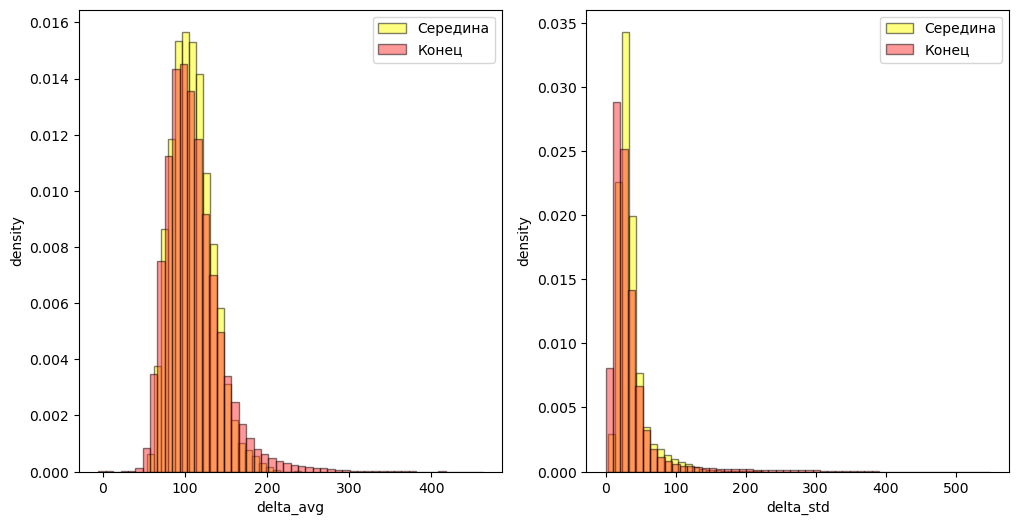

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(feats_mid.delta_avg, density=True, bins=22, color='#ffff00', alpha=0.5, edgecolor='black', label='Середина')
ax[0].hist(feats_end.delta_avg, density=True, bins=52, color='#ff3333', alpha=0.5, edgecolor='black', label='Конец')
ax[0].set_xlabel('delta_avg')
ax[0].set_ylabel('density')
ax[0].legend()

ax[1].hist(feats_mid.delta_std, density=True, bins=22, color='#ffff00', alpha=0.5, edgecolor='black', label='Середина')
ax[1].hist(feats_end.delta_std, density=True, bins=52, color='#ff3333', alpha=0.5, edgecolor='black', label='Конец')
ax[1].set_xlabel('delta_std')
ax[1].set_ylabel('density')
ax[1].legend()

plt.savefig('distribution_mid_last_5.png')
fig.show()

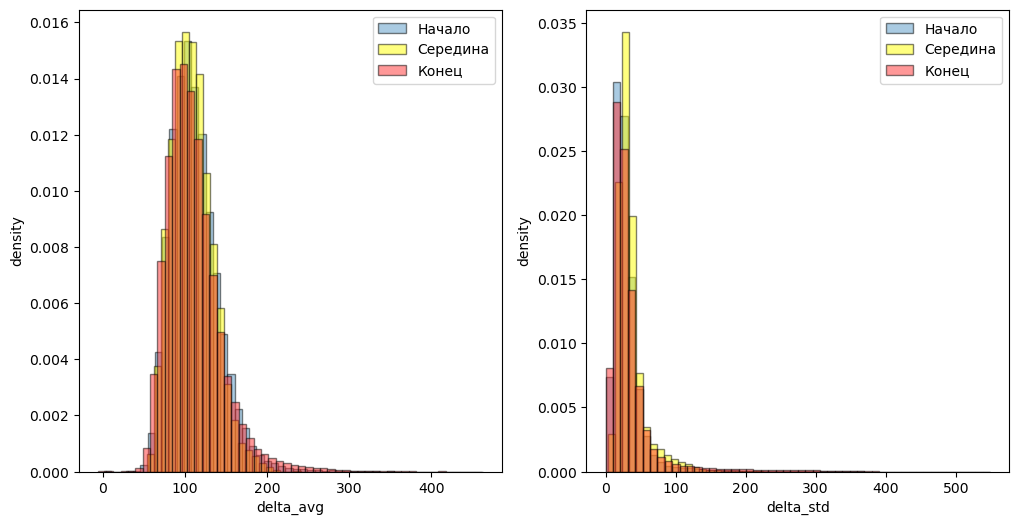

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(feats_start.delta_avg, density=True, bins=52, color='#5799C6', alpha=0.5, edgecolor='black', label='Начало')
ax[0].hist(feats_mid.delta_avg, density=True, bins=22, color='#ffff00', alpha=0.5, edgecolor='black', label='Середина')
ax[0].hist(feats_end.delta_avg, density=True, bins=52, color='#ff3333', alpha=0.5, edgecolor='black', label='Конец')
ax[0].set_xlabel('delta_avg')
ax[0].set_ylabel('density')
ax[0].legend()

ax[1].hist(feats_start.delta_std, density=True, bins=52, color='#5799C6', alpha=0.5, edgecolor='black', label='Начало')
ax[1].hist(feats_mid.delta_std, density=True, bins=22, color='#ffff00', alpha=0.5, edgecolor='black', label='Середина')
ax[1].hist(feats_end.delta_std, density=True, bins=52, color='#ff3333', alpha=0.5, edgecolor='black', label='Конец')
ax[1].set_xlabel('delta_std')
ax[1].set_ylabel('density')
ax[1].legend()

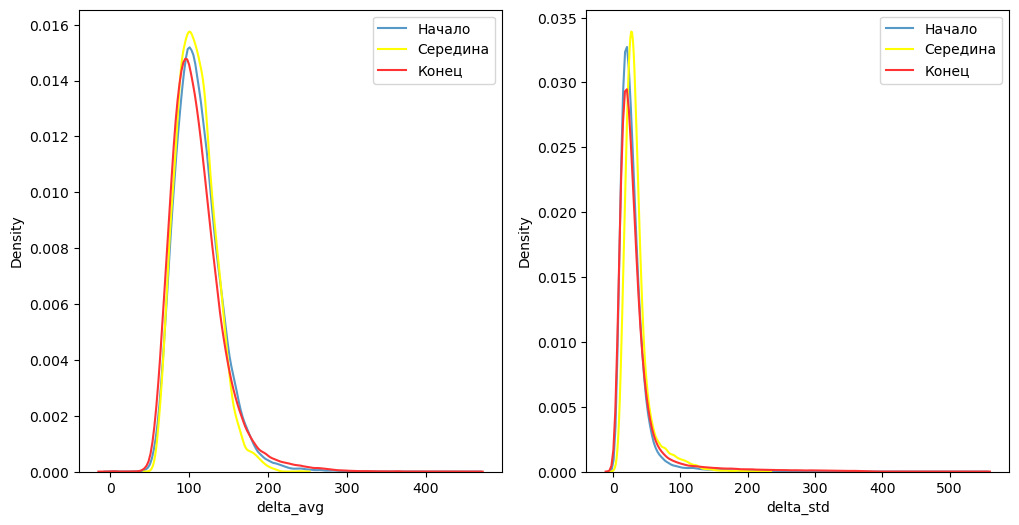

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.kdeplot(data=feats_start, x='delta_avg', color='#5799C6', ax=ax[0], label='Начало')
sns.kdeplot(data=feats_mid, x='delta_avg', color='#ffff00', ax=ax[0], label='Середина')
sns.kdeplot(data=feats_end, x='delta_avg', color='#ff3333', ax=ax[0], label='Конец')
ax[0].legend()

sns.kdeplot(data=feats_start, x='delta_std', color='#5799C6', ax=ax[1], label='Начало')
sns.kdeplot(data=feats_mid, x='delta_std', color='#ffff00', ax=ax[1], label='Середина')
sns.kdeplot(data=feats_end, x='delta_std', color='#ff3333', ax=ax[1], label='Конец')
ax[1].legend()

In [69]:
mapping = df[['id', 'participant_id']].drop_duplicates().set_index('id')
features['participant_id'] = features['id'].map(mapping['participant_id'])
features['participant_id'] = features['participant_id'].astype(int)

train = features.groupby('participant_id').head(8)
test = features[~features['id'].isin(train['id'])]
test = test[test['participant_id'].isin(train['participant_id'])]
train = train[train['participant_id'].isin(test['participant_id'])]

train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)
c()

train.shape[0], test.shape[0], train.shape[0] + test.shape[0], features.shape[0]

(80032, 70004, 150036, 150058)

In [71]:
x_train, y_train = train.iloc[:3000, :-1], train.iloc[:3000, -1]
x_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

In [15]:
x_train.describe()

,sentence_length,delta_avg,delta_std,flight_type1_avg,flight_type1_std,flight_type2_avg,flight_type2_std,flight_type3_avg,flight_type3_std,flight_type4_avg,flight_type4_std
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.558000,109.773311,39.324635,363.435031,195.570252,247.995287,199.438691,253.661720,190.765934,138.221975,195.384905
std,14.467548,24.034716,23.237603,119.307121,111.698118,113.390702,111.811066,114.381036,110.537038,113.383110,110.075858
min,16.000000,58.233333,9.245814,173.702703,30.143822,89.000000,36.948613,90.458333,28.447754,-46.272727,38.423721
25%,29.000000,91.952381,25.290265,277.979684,108.778574,164.368295,113.492002,170.427755,105.401382,57.832031,110.069353
50%,41.000000,110.417391,32.828113,342.887592,174.907059,227.701120,177.270968,234.235104,169.132807,119.620833,172.203920
75%,54.000000,124.491922,45.096425,424.954678,252.782357,303.895736,258.957817,308.558529,247.290189,190.966641,252.709131
max,70.000000,201.481481,168.666355,913.911765,705.547944,804.769231,701.137044,804.596154,709.730737,696.500000,705.400042


In [16]:
x_test.describe()

,sentence_length,delta_avg,delta_std,flight_type1_avg,flight_type1_std,flight_type2_avg,flight_type2_std,flight_type3_avg,flight_type3_std,flight_type4_avg,flight_type4_std
count,70004.000000,70004.000000,70003.000000,70004.000000,70003.000000,70004.000000,70003.000000,70004.000000,70003.000000,70004.000000,70003.000000
mean,41.483201,110.784902,37.785425,346.813022,177.214602,229.686403,182.061044,236.028120,172.306312,118.901501,178.068308
std,14.873289,23.509378,22.028358,115.757280,106.529917,107.191497,106.795477,109.012893,105.730817,105.411694,105.620930
min,13.000000,4.000000,3.128777,125.000000,20.886029,-26.294118,19.981057,65.222222,14.333105,-168.904762,21.706299
25%,29.000000,94.000000,24.876172,264.880411,98.250301,154.218410,103.307092,158.787879,94.513798,45.921900,100.839506
50%,40.000000,108.582184,31.587023,321.149074,149.752068,203.239389,154.047272,209.061455,144.967251,92.394644,149.953678
75%,54.000000,125.098529,42.117545,399.808712,229.943630,276.593483,233.810247,283.857143,224.450491,165.950000,228.898812
max,76.000000,240.800000,268.640406,1304.069767,802.499553,1141.272727,831.679271,1156.558140,787.063878,1027.000000,824.485220


# Baseline

In [72]:
unique_numbers = y_train.unique()
y_train = y_train.to_frame()

for number in unique_numbers:
    y_train[f'participant_{number}'] = (y_train['participant_id'] == number).astype(int)
y_train.drop(columns=['participant_id'], inplace=True)

In [73]:
unique_numbers = y_test.unique()
y_test = y_test.to_frame()

for number in unique_numbers:
    y_test[f'participant_{number}'] = (y_test['participant_id'] == number).astype(int)
y_test.drop(columns=['participant_id'], inplace=True)

In [74]:
cols_id = y_train.columns
array_metrics = []

for i, col in enumerate(cols_id):
    if i >= 375:
        continue
    print(i)
    try:
        arr = get_metrics(col)
        array_metrics.append(arr)
        c()
    except:
        pass
    
array_metrics = np.array(array_metrics)

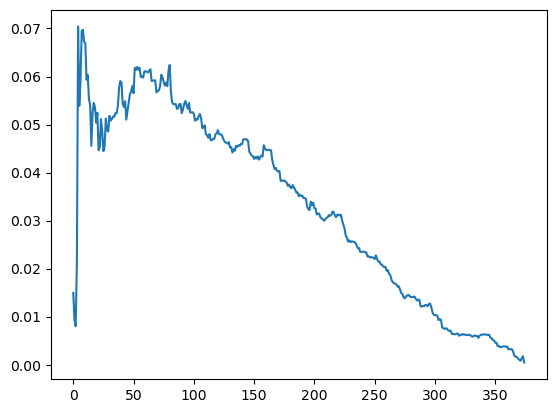

In [64]:
plt.plot(np.array(sorted(array_metrics[:, 0])) / np.array(sorted(1- (array_metrics[:, -3] + array_metrics[:, -2]) / 2)) - 1)

Text(0, 0.5, 'Значение')

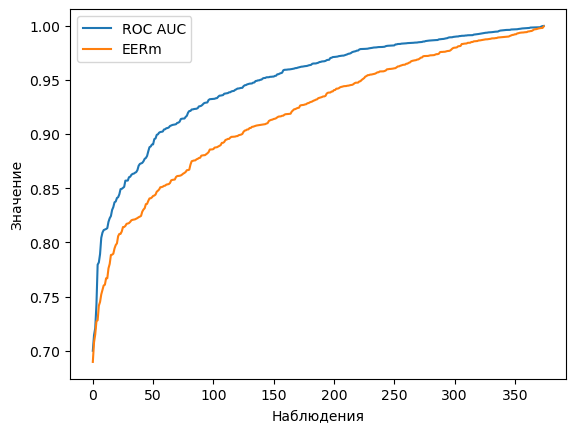

In [65]:
plt.plot(sorted(array_metrics[:, 0]), label='ROC AUC')
plt.plot(sorted(1- (array_metrics[:, -3] + array_metrics[:, -2]) / 2), label='EERm')
# plt.axhline(y=0.94822321, linestyle='--')
plt.legend()
plt.xlabel('Наблюдения')
plt.ylabel('Значение')

In [76]:
array_metrics.mean(axis=0)

array([0.95710477, 0.00447966, 0.72412698, 0.63569668, 0.14989305,
       0.        , 0.92505347, 0.07220168, 0.14292063, 0.89243884,
       0.04019776, 0.28660317, 0.83659953, 0.02591372, 0.42990476,
       0.77209076, 0.09243768, 0.03009524, 0.93873354])

In [75]:
tmp = array_metrics.mean(axis=0)
[(tmp[i]+tmp[i+1])/2 for i in range(1, len(tmp), 3)]

[0.3643033213889674,
 0.07494652620186901,
 0.10756115982621386,
 0.16340046770938754,
 0.22790924099223178,
 0.06126645691998818]

In [159]:
'train 80k', arr_FAR.mean(), arr_FRR.mean() # > 9000

('train 80k', 0.007675637037441353, 0.7521819843491174)

In [68]:
'train 10k', arr_FAR.mean(), arr_FRR.mean() #1200

('train 10k', 0.021469535572748635, 0.7076190476190475)

In [61]:
'train 5k', arr_FAR.mean(), arr_FRR.mean() #625

('train 5k', 0.021736907868132777, 0.7102476190476189)

In [54]:
'train 2.5k', arr_FAR.mean(), arr_FRR.mean() # 313

('train 2.5k', 0.023123492108713953, 0.7159592271413358)

In [34]:
'train 1k', arr_FAR.mean(), arr_FRR.mean() # 125

('train 1k', 0.013841507493178277, 0.7405714285714287)

In [27]:
def metrics(y, probs, threshold):

    probs = np.where(probs > threshold, 1, 0)
    cm = confusion_matrix(y, probs)

    FP = cm[0][1]
    TP = cm[1][1]

    FN = cm[1][0]
    TN = cm[0][0]

    FAR = FP / (FP + TN)
    FRR = FN / (FN + TP)
    roc_auc = roc_auc_score(y, probs)
    
    return FAR, FRR, roc_auc


def get_metrics(name):
    model = CatBoostClassifier(iterations=100, depth=2, metric_period=20)
    model.fit(x_train, y_train[name], verbose=False)

    y = y_test[name]
    probs = model.predict_proba(x_test)[:,1]
    roc_auc = roc_auc_score(y, probs)
    
    precision, recall, thresholds = precision_recall_curve(y, probs)
    recall = recall[:-1]
    precision = precision[:-1]
    f1_scores = 2*recall*precision/(recall+precision)
    threshold = thresholds[np.argmax(f1_scores[~np.isnan(f1_scores)])-1]
    FAR_f1, FRR_f1, roc_auc_f1 = metrics(y, probs, threshold)

    fpr, tpr, thresholds = roc_curve(y, probs)
    arg = np.argmax(tpr)
    threshold = thresholds[arg+1]
    FAR0, FRR0, roc_auc0 = metrics(y, probs, threshold)
    
    arg = np.argmax(tpr[:arg])
    threshold = thresholds[arg+1]
    FAR1, FRR1, roc_auc1 = metrics(y, probs, threshold)
    
    arg = np.argmax(tpr[:arg])
    threshold = thresholds[arg+1]
    FAR2, FRR2, roc_auc2 = metrics(y, probs, threshold)

    arg = np.argmax(tpr[:arg])
    threshold = thresholds[arg+1]
    FAR3, FRR3, roc_auc3 = metrics(y, probs, threshold)
    
    idx = np.argmax(tpr - fpr)
    threshold = thresholds[idx+1]
    FARm, FRRm, roc_aucm = metrics(y, probs, threshold)
    
    arr = np.array([
        roc_auc,
        FAR_f1, FRR_f1, roc_auc_f1, 
        FAR0, FRR0, roc_auc0,
        FAR1, FRR1, roc_auc1,
        FAR2, FRR2, roc_auc2,
        FAR3, FRR3, roc_auc3,
        FARm, FRRm, roc_aucm,
    ])
    return arr

In [ ]:
idxes = [
    'roc_auc',
    'FAR_f1', 'FRR_f1', 'roc_auc_f1', 
    'FAR0', 'FRR0', 'roc_auc0',
    'FAR1', 'FRR1', 'roc_auc1',
    'FAR2', 'FRR2', 'roc_auc2',
    'FAR3', 'FRR3', 'roc_auc3',
    'FARm', 'FRRm', 'roc_aucm',
]
df_show = pd.DataFrame(columns=idxes)
array_all_metrics = []

for j in range(10):
    
    mapping = df[['id', 'participant_id']].drop_duplicates().set_index('id')
    features['participant_id'] = features['id'].map(mapping['participant_id'])
    features['participant_id'] = features['participant_id'].astype(int)
    train = features.groupby('participant_id').head(2+j)
    test = features[~features['id'].isin(train['id'])]
    test = test[test['participant_id'].isin(train['participant_id'])]
    train = train[train['participant_id'].isin(test['participant_id'])]
    train.drop(columns=['id'], inplace=True)
    test.drop(columns=['id'], inplace=True)
    x_train, y_train = train.iloc[:3000, :-1], train.iloc[:3000, -1]
    x_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
    unique_numbers = y_train.unique()
    y_train = y_train.to_frame()
    for number in unique_numbers:
        y_train[f'participant_{number}'] = (y_train['participant_id'] == number).astype(int)
    y_train.drop(columns=['participant_id'], inplace=True)
    unique_numbers = y_test.unique()
    y_test = y_test.to_frame()
    for number in unique_numbers:
        y_test[f'participant_{number}'] = (y_test['participant_id'] == number).astype(int)
    y_test.drop(columns=['participant_id'], inplace=True)
    
    cols_id = y_train.columns
    array_metrics = []
    for i, col in enumerate(cols_id):
        if i >= 375:
            continue
        print(i)
        try:
            arr = get_metrics(col)
            array_metrics.append(arr)
        except:
            pass
        c()
    array_metrics = np.array(array_metrics)
    array_all_metrics.append(array_metrics)
    df_show.loc[j] = array_metrics.mean(axis=0)
    
df_show

74


In [77]:
name = 'participant_36'

model = CatBoostClassifier(iterations=100, depth=2, metric_period=20)
model.fit(x_train, y_train[name], verbose=False)

y = y_test[name]
probs = model.predict_proba(x_test)[:,1]

fpr, tpr, thresholds = roc_curve(y, probs)
arg = np.argmax(tpr[:np.argmax(tpr)])
arg = np.argmax(tpr)
threshold = thresholds[arg+1]

probs = np.where(probs > threshold, 1, 0)
roc_auc = roc_auc_score(y, probs)
prec = precision_score(y, probs)
rec = recall_score(y, probs)
f1 = f1_score(y, probs)
print('\nROC-AUC', round(roc_auc, 3), '\n')#, prec, rec, f1)
print(classification_report(y, probs))


ROC-AUC 0.942 

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     69997
           1       0.00      1.00      0.00         7

    accuracy                           0.88     70004
   macro avg       0.50      0.94      0.47     70004
weighted avg       1.00      0.88      0.94     70004



In [78]:
confusion_matrix(y, probs)

array([[61887,  8110],
       [    0,     7]], dtype=int64)

In [79]:
cm = confusion_matrix(y, probs)

FP = cm[0][1]
TP = cm[1][1]

FN = cm[1][0]
TN = cm[0][0]

FAR = FP / (FP + TN)
FRR = FN / (FN + TP)

print(f'FAR: {FAR}\nFRR: {FRR}')

FAR: 0.11586210837607326
FRR: 0.0


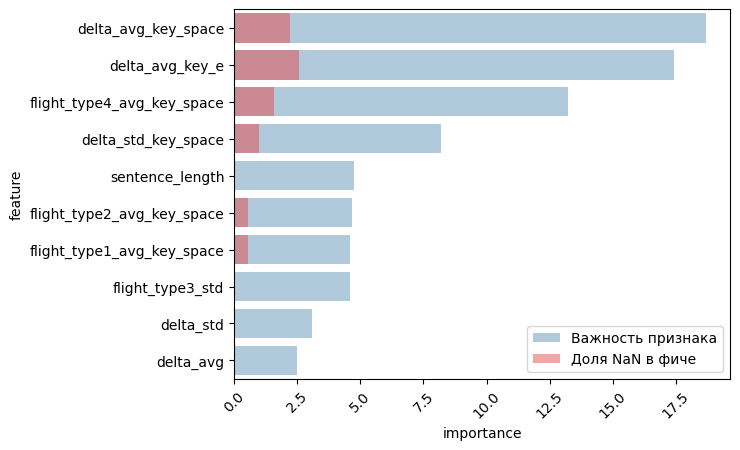

In [80]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = model.feature_names_
feature_importance['importance'] = model.feature_importances_
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
# feature_importance.head(40)
mapping = x_test.isna().sum(axis=0) / x_test.shape[0]
feature_importance['NaN'] = feature_importance['feature'].map(mapping) * feature_importance['importance']

sns.barplot(feature_importance.head(10), x='importance', y='feature', color='#5799C6', alpha=0.5, label='Важность признака')
plt.legend()
sns.barplot(feature_importance.head(10), x='NaN', y='feature', color='#ff3333', alpha=0.5, label='Доля NaN в фиче')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('importance')
plt.show()

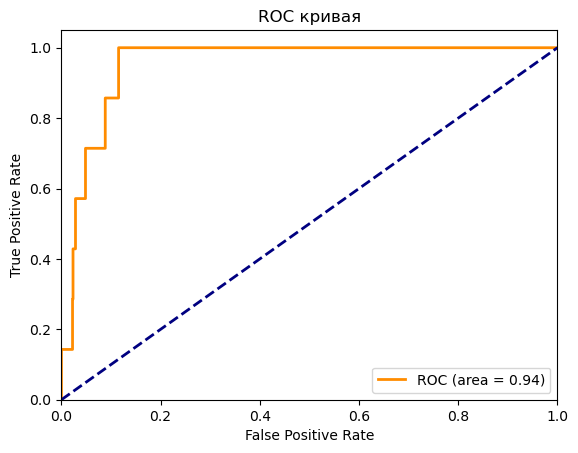

In [82]:
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(x_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()

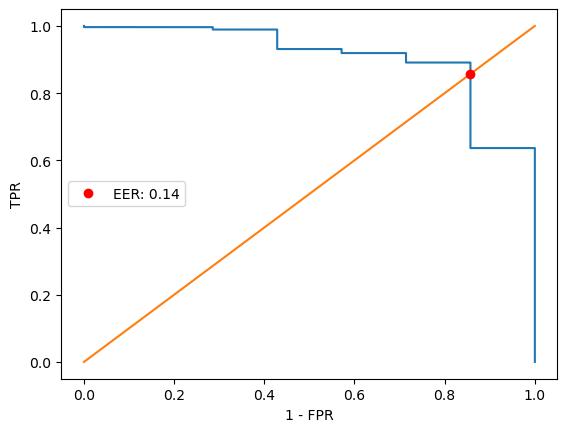

In [55]:
# plt.plot(thresholds, tpr)
# plt.plot(thresholds, 1-np.flip(fpr))
plt.plot(tpr, 1-fpr)
plt.plot(tpr, tpr)

plt.plot(x_intersection, y_intersection, 'ro', label=f'EER: {np.round(1-(x_intersection), 2)[0]}')
plt.xlabel('1 - FPR')
plt.ylabel('TPR')
plt.legend()

In [110]:
y1 = 1-fpr
y2 = tpr

idx = np.argwhere(np.diff(np.sign(y1 - y2))).flatten()
x_intersection = tpr[idx]
y_intersection = y1[idx]
x_intersection, y_intersection

(array([0.9]), array([0.91382862]))

In [74]:
idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[idx+1]

print("Оптимальная граница:", optimal_threshold)

Оптимальная граница: 0.0048059026902935505


In [ ]:
FAR = number of false positives ÷ (number of false positives + number of true negatives)
FRR = number of false negatives ÷ (number of false negatives + number of true positives)